In [7]:
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
%matplotlib inline 

2.0.0


In [2]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv -O /tmp/sunspots.csv

--2019-10-07 00:42:34--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com... 172.217.160.144
Connecting to storage.googleapis.com|172.217.160.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.04s   

2019-10-07 00:42:35 (1.59 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [3]:
import csv

sunspots = []
time_step = []
with open('/tmp/sunspots.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

In [4]:
import numpy as np

series = np.array(sunspots)
time = np.array(time_step)

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 64
batch_size = 256
shuffle_buffer_size = 1000    

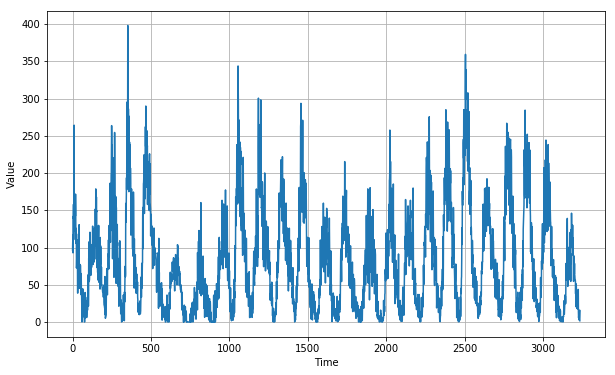

In [8]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [12]:
def windowed_dataset(series, window_size, shuffle_buffer, batch_size=32):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
def get_model():
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400.0)
    ])
    return model

In [13]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = get_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9), metrics=['mae'])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)
history = model.fit(dataset, epochs=100, verbose=0, callbacks=[lr_schedule])

[1e-08, 0.01, 20, 100]

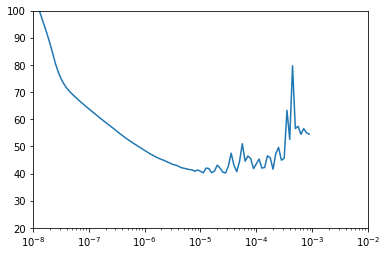

In [15]:
plt.semilogx(history.history['lr'], history.history["loss"])
plt.axis([1e-8, 1e-2, 20, 100])

In [17]:
results = model_forecast(model, series[..., np.newaxis], window_size)
results = results[split_time - window_size:-1, -1, 0]
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

52.433422

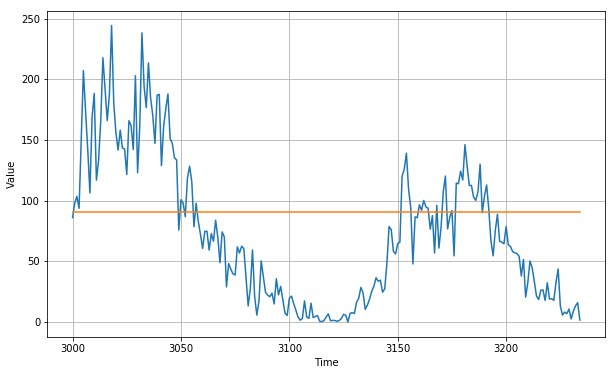

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

_3_layer_model = get_model()
_3_layer_model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)
history = _3_layer_model.fit(dataset, epochs=500, verbose=0)

In [ ]:
results = model_forecast(model, series[..., np.newaxis], window_size)
results = results[split_time - window_size:-1, -1, 0]
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()